# Sistema geotérmico de Acoculco

## Geofísica Matemática y Computacional

### Arturo Cruz López

#### 


### Modelo conceptual

Acoculco es un sistema geotérmico que se encuentra en la parte Este de la Faja Volcánica Trans-mexicana. Los registros térmicos de un pozo con 4000 m de profundidad muestra un régimen de transferencia conductivo bajo un gradiente geotérmico.

Se tiene como propósito determinar la transferencia de calor, mediante un modelo 1D, simulando la distribución tiempo-profundidad de la temperatura, mediante el método de diferencias finitas.

Las características del modelo conceptual son las siguientes:

1. Régimen de transferencia de calor por conducción.
2. Se supone una estructura estratificada subterránea, en donde cada capa es isótropa y tiene propiedades constantes.
2. Uso del método de diferencias finitas.
3. Se utiliza, para ello, la resolución de una ecuación por balance de calor.
4. En el modelo, no se consideran fuentes ni sumideros.
5. El régimen NO Estacionario, es decir, depende del tiempo.
6. Las temperaturas inicial y final son fijas en los extremos (condiciones de frontera).

$T = $ temperatura

$z = $ profundidad

$\kappa = $ conductividad térmica

$c = $ capacidad calorífica específica (valor experimental dado)

$\rho = $ densidad de masa (valor experimental dado)


### Modelo matemático

La ecuación de balance de calor en 1D, se describe como sigue:

$\frac{\partial{T}}{\partial{t}} = D_{th} \frac{\partial{T^2}}{\partial{z^2}}$

En donde $\frac{\partial{T}}{\partial{t}}$ ES DIFERENTE de 0 

entonces, podemos expresar de otra manera esta ecuación para un mejor entendimiento,
pasando de la ec (1) a la ec (2)

$ D_{th} \frac{\partial{T^2}}{\partial{z^2}} = \frac{\partial{T}}{\partial{t}}$ (1)

$ \frac{\partial{}}{\partial{z}} (D_{th} \frac{\partial{T}}{\partial{z}}) = \frac{\partial{T}}{\partial{t}}$ (2)

$ D_{th}$ se define como:

$ D_{th}= \frac{\kappa}{\rho c}$

$T = $ temperatura

$z = $ profundidad

$\kappa = $ conductividad térmica

$c = $ capacidad calorífica específica

$\rho = $ densidad de masa

$L = 4000$ profundidad maxima del pozo

$T_A = $ 15°C 

$T_B = $ 750°C 

Condiciones de Direchlet, que se determinan por la información del artículo:

$T(z=0) = T_A$

$T(z=4000) = T_B$


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import interpolate
from fdm_1D import Laplaciano1D_NS, calcDth, interpTemp

In [2]:
#
# Datos físicos del problema
#
Ttop = 15   # Temperatura en la superficie
Tbot = 750  # Temperatura a 4000 m
L = 4000.0  # Profundidad máxima
data = pd.read_csv('phys_dat.csv') # Lectura de datos: k, cp, rho
Dth_data = data['k'] / (data['rho']*data['cp']) # Cálculo del coeficiente Dth

print('\nDatos del problema \n{}'.format(data))
print('\n Dth : \n{}'.format(Dth_data))
#input('Presiona <enter>')
#
# Datos para la solución numérica por diferencias finitas
#
N = 99                      # Número de incógnitas
dx = L / (N+1)              # Distancia entre nodos
z = np.linspace(0, L, N+2)  # Coordenada z de la profundidad
dt = 3600*24*365 # Paso de tiempo (seconds per year)
NT = 250000      # Número total de pasos de tiempo

print('\nDatos para la solución numérica usando FD')
print(' dx = {:10.1f} [m] \n L  = {:10.1f} [m] \n N  = {:8d}'.format(dx, L, N))
print(' dt = {:10.1f} [s] \n NT = {:8d}'.format(dt, NT))
#
# Aceleración para el método implícito
#
SP = 1000
dt *= SP
NT /= SP
print('\nUsamos un factor de aceleración debido al método implícito: ')
print(' SP = {:13d} (factor)\n dt = {:15.1f} [s] \n NT = {:13d} (pasos totales)'.format(SP, dt, int(NT)))
print('\nz shape = {} \n{}'.format(z.shape,z))
#input('Presiona <enter>')
#
# Vector con el valor del coeficiente dependiendo de la profundidad 
#
Dth = calcDth(Dth_data, z, N)
        
print('\nCoeficiente en los puntos de la simulación: \n D_th shape = {} \n{}'.format(Dth.shape, Dth))
#
# SOLUCIÓN USANDO DIFERENCIAS FINITAS
#
# Condición inicial: Profundidades
z_dat = [0, 100, 200, 400, 710, 803, 1100, 1200, 1400, 1500, 1600, 1700, 1800, 2000, 2500, 3000, 3500, 4000]
# Condición inicial: Temperaturas
T_dat = [15, 113, 145, 178, 155, 201, 215, 282, 223, 226, 252, 284, 310, 350, 450, 550, 650, 750]
# Interpolación a los lugares de la simulación

T_ini = interpTemp(z_dat, T_dat,z)

#
# Temperaturas actuales
z_dat_now = [0, 96, 192, 389, 596, 798, 1000, 1197, 1408, 1495, 1586, 1649, 1702, 1750, 1803, 1851, 1904, 1942, 1967, 2000, 2500, 3000, 3500, 4000]
T_dat_now = [15, 69, 74, 95, 121, 159, 168, 192, 213, 213, 236, 251, 267, 272, 284, 288, 298, 293, 310, 325, 440, 550, 650, 750]
# Interpolación a los lugares de la simulación

T_fin = interpTemp(z_dat_now, T_dat_now,z)

#
# SOLUCIÓN USANDO DIFERENCIAS FINITAS
#
# Definicion del sistema lineal de N x N
#
dt_dx2 = dt / dx**2
gamma = Dth * dt_dx2
A = Laplaciano1D_NS(N, gamma) # Matriz del sistema

print('\nGamma shape = {}, A shape = {}'.format(gamma.shape, A.shape))
#
# Ciclo de solución temporal
#
T_new = T_ini.copy()
T_now = np.zeros(N+2)
for i in range(0, int(NT)+1):
    print(i)
    T_new[ 1] += gamma[0] * T_ini[0]
    T_new[-2] += gamma[-1] * T_ini[-1]    
    T_new[1:-1] = np.linalg.solve(A,T_new[1:-1])
    if (i == 7):
        T_now = T_new.copy() # Temperatura actual



Datos del problema 
   depth1  depth2     k     cp     rho
0       0      50  1.84  840.0  2120.0
1      50     250  1.41  840.0  2340.0
2     250     400  1.36  840.0  2300.0
3     400     600  1.44  840.0  2300.0
4     600     800  1.46  840.0  2290.0
5     800    1000  1.68  840.0  2700.0
6    1000    1500  1.84  890.0  2700.0
7    1500    1900  1.66  890.0  2360.0
8    1900    4000  2.10  950.0  2760.0

 Dth : 
0    1.033243e-06
1    7.173382e-07
2    7.039337e-07
3    7.453416e-07
4    7.589936e-07
5    7.407407e-07
6    7.657095e-07
7    7.903257e-07
8    8.009153e-07
dtype: float64

Datos para la solución numérica usando FD
 dx =       40.0 [m] 
 L  =     4000.0 [m] 
 N  =       99
 dt = 31536000.0 [s] 
 NT =   250000

Usamos un factor de aceleración debido al método implícito: 
 SP =          1000 (factor)
 dt =   31536000000.0 [s] 
 NT =           250 (pasos totales)

z shape = (101,) 
[   0.   40.   80.  120.  160.  200.  240.  280.  320.  360.  400.  440.
  480.  520.  560.

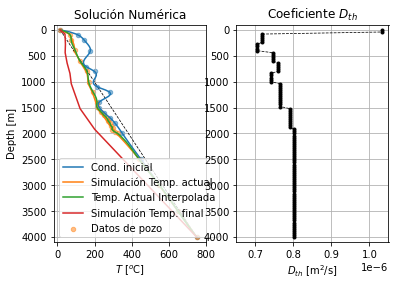

In [3]:
#
# GRAFICACIÓN
#
ax1 = plt.subplot(121)
plt.plot([T_ini[0], T_ini[-1]], [z[0], z[-1]], '--', lw=0.75, c='k' )
plt.scatter(T_dat, z_dat, s=20, alpha=0.5)
plt.plot(T_ini, z, '-', lw = 1.5, label='Cond. inicial')

plt.scatter(T_dat_now, z_dat_now, s=20, alpha=0.5, label='Datos de pozo')
plt.plot(T_now, z, label='Simulación Temp. actual')
plt.plot(T_fin, z, label= 'Temp. Actual Interpolada')
plt.plot(T_new,z, label='Simulación Temp. final')
plt.ylim(4100,-100)
plt.xlim(-20,800)
plt.title('Solución Numérica')
plt.xlabel('$T$ [$^o$C]')
plt.ylabel('Depth [m]')
plt.grid()
plt.legend()

ax2 = plt.subplot(122, sharey=ax1)
plt.plot(Dth, z, 'k.--', lw=0.75)
plt.xlabel('$D_{th}$ [m$^2$/s]')
plt.xlim(0.65e-6,1.05e-6)
plt.ticklabel_format(axis='x', style='sci', scilimits=(0,0))
plt.title('Coeficiente $D_{th}$')
plt.grid()

plt.subplots_adjust(hspace=1.0)

plt.show()

### Experimentando con el numero de NT y de N


Datos del problema 
   depth1  depth2     k     cp     rho
0       0      50  1.84  840.0  2120.0
1      50     250  1.41  840.0  2340.0
2     250     400  1.36  840.0  2300.0
3     400     600  1.44  840.0  2300.0
4     600     800  1.46  840.0  2290.0
5     800    1000  1.68  840.0  2700.0
6    1000    1500  1.84  890.0  2700.0
7    1500    1900  1.66  890.0  2360.0
8    1900    4000  2.10  950.0  2760.0

 Dth : 
0    1.033243e-06
1    7.173382e-07
2    7.039337e-07
3    7.453416e-07
4    7.589936e-07
5    7.407407e-07
6    7.657095e-07
7    7.903257e-07
8    8.009153e-07
dtype: float64
0
1
2
3
4
5
6
7
8
9
10


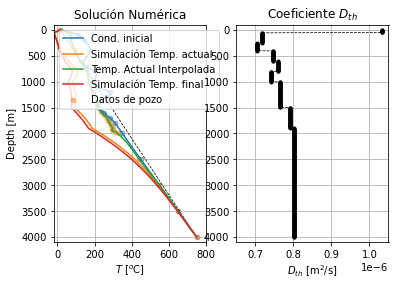

In [4]:
#
# Datos físicos del problema
#
Ttop = 15   # Temperatura en la superficie
Tbot = 750  # Temperatura a 4000 m
L = 4000.0  # Profundidad máxima
data = pd.read_csv('phys_dat.csv') # Lectura de datos: k, cp, rho
Dth_data = data['k'] / (data['rho']*data['cp']) # Cálculo del coeficiente Dth

print('\nDatos del problema \n{}'.format(data))
print('\n Dth : \n{}'.format(Dth_data))
#input('Presiona <enter>')
#
# Datos para la solución numérica por diferencias finitas
#
N = 500                      # Número de incógnitas
dx = L / (N+1)              # Distancia entre nodos
z = np.linspace(0, L, N+2)  # Coordenada z de la profundidad
dt = 3600*24*365 # Paso de tiempo (seconds per year)
NT = 10000     # Número total de pasos de tiempo

# print('\nDatos para la solución numérica usando FD')
# print(' dx = {:10.1f} [m] \n L  = {:10.1f} [m] \n N  = {:8d}'.format(dx, L, N))
# print(' dt = {:10.1f} [s] \n NT = {:8d}'.format(dt, NT))
# #
# Aceleración para el método implícito
#
SP = 1000
dt *= SP
NT /= SP
# print('\nUsamos un factor de aceleración debido al método implícito: ')
# print(' SP = {:13d} (factor)\n dt = {:15.1f} [s] \n NT = {:13d} (pasos totales)'.format(SP, dt, int(NT)))
# print('\nz shape = {} \n{}'.format(z.shape,z))
#input('Presiona <enter>')
#
# Vector con el valor del coeficiente dependiendo de la profundidad 
#
Dth = calcDth(Dth_data, z, N)
        
#print('\nCoeficiente en los puntos de la simulación: \n D_th shape = {} \n{}'.format(Dth.shape, Dth))
#
# SOLUCIÓN USANDO DIFERENCIAS FINITAS
#
# Condición inicial: Profundidades
z_dat = [0, 100, 200, 400, 710, 803, 1100, 1200, 1400, 1500, 1600, 1700, 1800, 2000, 2500, 3000, 3500, 4000]
# Condición inicial: Temperaturas
T_dat = [15, 113, 145, 178, 155, 201, 215, 282, 223, 226, 252, 284, 310, 350, 450, 550, 650, 750]
# Interpolación a los lugares de la simulación

T_ini = interpTemp(z_dat, T_dat,z)

#
# Temperaturas actuales
z_dat_now = [0, 96, 192, 389, 596, 798, 1000, 1197, 1408, 1495, 1586, 1649, 1702, 1750, 1803, 1851, 1904, 1942, 1967, 2000, 2500, 3000, 3500, 4000]
T_dat_now = [15, 69, 74, 95, 121, 159, 168, 192, 213, 213, 236, 251, 267, 272, 284, 288, 298, 293, 310, 325, 440, 550, 650, 750]
# Interpolación a los lugares de la simulación

T_fin = interpTemp(z_dat_now, T_dat_now,z)

#
# SOLUCIÓN USANDO DIFERENCIAS FINITAS
#
# Definicion del sistema lineal de N x N
#
dt_dx2 = dt / dx**2
gamma = Dth * dt_dx2
A = Laplaciano1D_NS(N, gamma) # Matriz del sistema

#print('\nGamma shape = {}, A shape = {}'.format(gamma.shape, A.shape))
#
# Ciclo de solución temporal
#
T_new = T_ini.copy()
T_now = np.zeros(N+2)
for i in range(0, int(NT)+1):
    print(i)
    T_new[ 1] += gamma[0] * T_ini[0]
    T_new[-2] += gamma[-1] * T_ini[-1]    
    T_new[1:-1] = np.linalg.solve(A,T_new[1:-1])
    if (i == 7):
        T_now = T_new.copy() # Temperatura actual
        
#
# GRAFICACIÓN
#
ax1 = plt.subplot(121)
plt.plot([T_ini[0], T_ini[-1]], [z[0], z[-1]], '--', lw=0.75, c='k' )
plt.scatter(T_dat, z_dat, s=20, alpha=0.5)
plt.plot(T_ini, z, '-', lw = 1.5, label='Cond. inicial')

plt.scatter(T_dat_now, z_dat_now, s=20, alpha=0.5, label='Datos de pozo')
plt.plot(T_now, z, label='Simulación Temp. actual')
plt.plot(T_fin, z, label= 'Temp. Actual Interpolada')
plt.plot(T_new,z, label='Simulación Temp. final')
plt.ylim(4100,-100)
plt.xlim(-20,800)
plt.title('Solución Numérica')
plt.xlabel('$T$ [$^o$C]')
plt.ylabel('Depth [m]')
plt.grid()
plt.legend()

ax2 = plt.subplot(122, sharey=ax1)
plt.plot(Dth, z, 'k.--', lw=0.75)
plt.xlabel('$D_{th}$ [m$^2$/s]')
plt.xlim(0.65e-6,1.05e-6)
plt.ticklabel_format(axis='x', style='sci', scilimits=(0,0))
plt.title('Coeficiente $D_{th}$')
plt.grid()

plt.subplots_adjust(hspace=1.0)

plt.show()